In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

from create_input.lmp.info_from_lmp_out import LammpsLogParser
from scf.qelattice import get_qel

In [94]:
# path2root = '/Users/y1u0d2/desktop/Lab/result/lammps/Si/two-body-potential/ml-zbl/model_7'
# result_ml_zbl = get_two_body_result(path2root, interatomic_distance_range)
# result_ml_zbl[:, 1] = result_ml_zbl[:,1] + 1264.7168
def get_dimer_result(path2target):
    dirs = glob(f'{path2target}/scf*')
    result = []
    for d in dirs:
        try:
            qel = get_qel(d)
            coord = qel.get_coord()
            vol = qel.get_vol()
            dist = np.linalg.norm(coord[0]-coord[1])
            result.append([vol, dist, qel.get_energy(), d.split('/')[-1]])
        except Exception as e:
            print(d, e)
            
    return pd.DataFrame(data=result, columns=['vol', 'distance', 'energy', 'path'])

path2target = '/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/01/result'
result_qe = get_dimer_result(path2target)
result_qe = result_qe.sort_values(by='distance')
result_qe = result_qe.reset_index(drop=True)
result_qe['energy'] = result_qe['energy'] + 1261

/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/01/result/scf_34 invalid: convergence NOT achieved
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/01/result/scf_94 invalid: convergence NOT achieved
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/01/result/scf_93 invalid: convergence NOT achieved
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/01/result/scf_69 invalid: convergence NOT achieved
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/01/result/scf_68 invalid: convergence NOT achieved
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/01/result/scf_92 invalid: convergence NOT achieved
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/01/result/scf_95 invalid: convergence NOT achieved
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/01/result/scf_0 invalid: convergence NOT achieved
/Users/y1u0d2/desktop/Lab/result/qe/Si/mp-149_dimer/coord/01/result/scf_1 invalid: convergence NOT achieved
/Users/y1u0d2/desktop

/var/folders/hl/8xx4rtm50t7czkr79gggbqqr0000gr/T/ipykernel_54886/4068890637.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


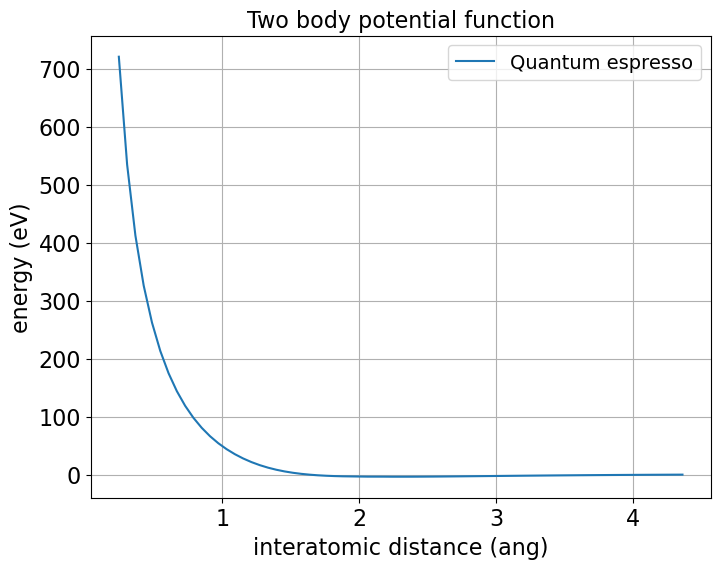

In [95]:
def plot_two_body(result, label, ax):
    ax.plot(result[:,0], result[:,1], label=label, lw=2)

fs = 16

fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot(111)

ax.plot(result_qe['distance'], result_qe['energy'], label='Quantum espresso')

ax.set_title('Two body potential function', fontsize=fs)
ax.set_xlabel('interatomic distance (ang)', fontsize=fs)
ax.set_ylabel('energy (eV)', fontsize=fs)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid()
ax.legend(fontsize=14)

# ax.set_ylim(-5, 10)
# ax.set_ylim(-50, 500)

fig.show()

In [96]:
# fit_qe_df = result_qe.query('distance < 1.6')
fit_qe_df = result_qe.query('distance < 1.0')

In [97]:
from scipy.optimize import curve_fit

In [98]:
distance = fit_qe_df['distance'].values
energy = fit_qe_df['energy'].values

In [99]:
def qe(x, Z, a, b, c):
    return (Z**2 / x**3) + a / x ** 2 + b / x + c

def qe_func(x, param):
    return (param[0]**2 / x**3) + param[1] / x ** 2 + param[2] / x + param[3]
# def qe(x, Z):
#     return (Z**2 / x**3)

# def qe_func(x, param):
#     return (param[0]**2 / x**3)

param, cov = curve_fit(qe, distance, energy)

/Users/y1u0d2/opt/anaconda3/envs/ml/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [100]:
energy_fit = [qe_func(x, param) for x in distance]

/var/folders/hl/8xx4rtm50t7czkr79gggbqqr0000gr/T/ipykernel_54886/2662158343.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


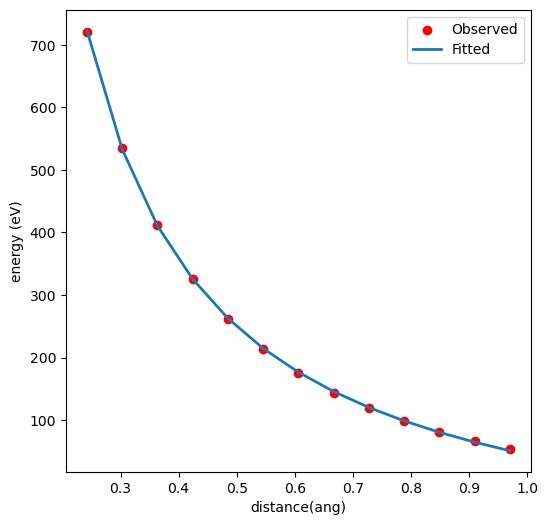

In [101]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.scatter(distance, energy, label='Observed', color='red')
ax.plot(distance, energy_fit, label='Fitted', linewidth=2)

ax.set_xlabel('distance(ang)')
ax.set_ylabel('energy (eV)')
# ax.set_ylim(0, 100)

ax.legend()
fig.show()

In [102]:
param

array([-2.76728076e-05,  5.73933071e+00,  1.87472724e+02, -1.48409871e+02])

In [103]:
def ga_fit_func(x):
    return 9.45897406**2 / x**3 -27.47400958/x**2 -4.50065353/x

def qe_fit_func(x):
    return -2.76728076e-05**2 / x**3 + 5.73933071 / x**2 + 1.87472724e+02 / x - 1.48409871e+02 

In [104]:
result_qe['qe_correction'] = result_qe['distance'].map(qe_fit_func)
result_qe['ga_correction'] = result_qe['distance'].map(ga_fit_func)

In [105]:
result_qe['combined_energy'] = result_qe['energy'] - result_qe['qe_correction'] + result_qe['ga_correction']

In [106]:
hartree2ev = 27.2114
summary_df = pd.read_csv('/Users/y1u0d2/desktop/Lab/result/gaussian/Si/comparison_of_basis_set_and_spin_summary.csv')

summary_df['6-31G'] = summary_df['6-31G'] + (289.198876197 * hartree2ev * 2)
summary_df['6-311G'] = summary_df['6-311G'] + (289.223331428 * hartree2ev * 2)
summary_df['6-311Gdp'] = summary_df['6-311Gdp'] + 15739.808470

/var/folders/hl/8xx4rtm50t7czkr79gggbqqr0000gr/T/ipykernel_54886/1103513923.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


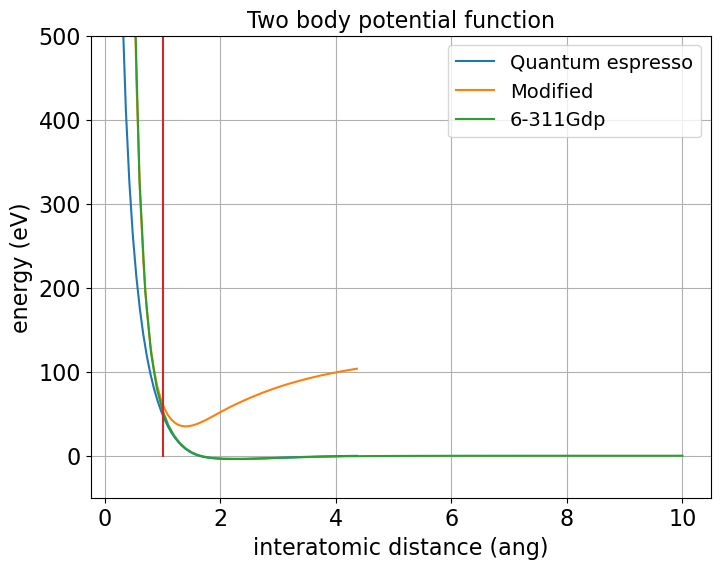

In [107]:
fs = 16

fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot(111)

ax.plot(result_qe['distance'], result_qe['energy'], label='Quantum espresso')
ax.plot(result_qe['distance'], result_qe['combined_energy'], label='Modified')
ax.plot(summary_df['distance'], summary_df['6-311Gdp'], label='6-311Gdp')

ax.plot([1]*10, np.linspace(0, 500, 10))

ax.set_title('Two body potential function', fontsize=fs)
ax.set_xlabel('interatomic distance (ang)', fontsize=fs)
ax.set_ylabel('energy (eV)', fontsize=fs)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid()
ax.legend(fontsize=14)

# ax.set_ylim(-5, 10)
ax.set_ylim(-50, 500)

fig.show()

In [108]:
result_qe

,vol,distance,energy,path,qe_correction,ga_correction,combined_energy
0,3375.0,0.242430,720.985815,scf_3,722.550410,5793.526681,5791.962087
1,3375.0,0.303030,534.901068,scf_4,532.752173,2901.327014,2903.475908
2,3375.0,0.363630,412.356260,scf_5,410.554350,1640.683166,1642.485076
3,3375.0,0.424245,326.020595,scf_6,325.375475,1008.502122,1009.147242
4,3375.0,0.484845,262.230431,scf_7,262.670327,658.861234,658.421338
...,...,...,...,...,...,...,...
56,3375.0,3.818175,-0.794730,scf_62,-98.916099,-1.455919,96.665450
57,3375.0,3.878790,-0.703048,scf_63,-99.695608,-1.453243,97.539317
58,3375.0,4.060605,-0.452997,scf_66,-101.893122,-1.438285,100.001840
59,3375.0,4.121205,-0.377573,scf_67,-102.582168,-1.431433,100.773163


/var/folders/hl/8xx4rtm50t7czkr79gggbqqr0000gr/T/ipykernel_54886/3564028443.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


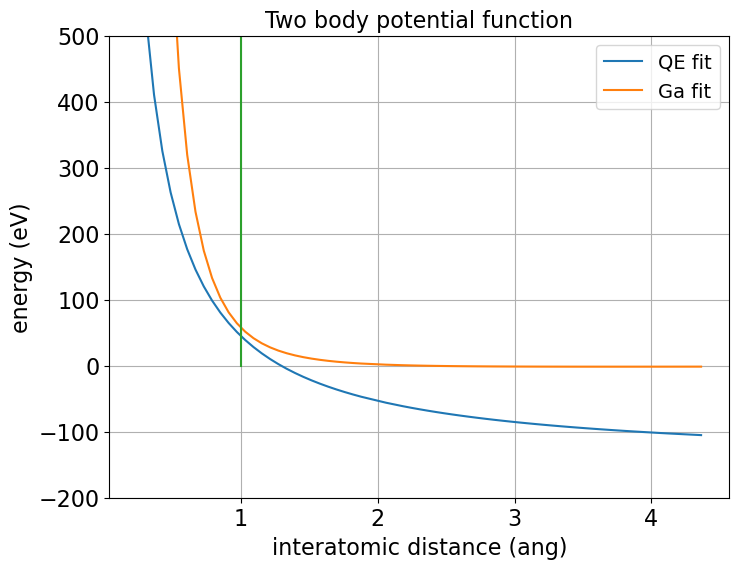

In [109]:
fs = 16

fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot(111)

ax.plot(result_qe['distance'], result_qe['qe_correction'], label='QE fit')
ax.plot(result_qe['distance'], result_qe['ga_correction'], label='Ga fit')

ax.plot([1]*10, np.linspace(0, 500, 10))

ax.set_title('Two body potential function', fontsize=fs)
ax.set_xlabel('interatomic distance (ang)', fontsize=fs)
ax.set_ylabel('energy (eV)', fontsize=fs)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid()
ax.legend(fontsize=14)

# ax.set_ylim(-5, 10)
ax.set_ylim(-200, 500)

fig.show()

In [110]:
# Plot two-body potential of qefit (lammps output)
path2target = '/Users/y1u0d2/desktop/Lab/result/lammps/Si/two-body-potential/qefit/01'
pathes = glob(f'{path2target}/tb*')
pathes.sort()

result_lmp = []
for path in pathes:
    r_from_path = float(path.split('/')[-1].split('_')[-1])
    obj = LammpsLogParser(path2target=path, dump_filename='dump.out')
    energy = obj.get_energy()
    result_lmp.append([r_from_path, energy])

result_lmp_df = pd.DataFrame(data=result_lmp, columns=['distance', 'energy'])

In [111]:
result_lmp_df['qefit'] = result_lmp_df['distance'].apply(qe_fit_func)

/var/folders/hl/8xx4rtm50t7czkr79gggbqqr0000gr/T/ipykernel_54886/3048539814.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


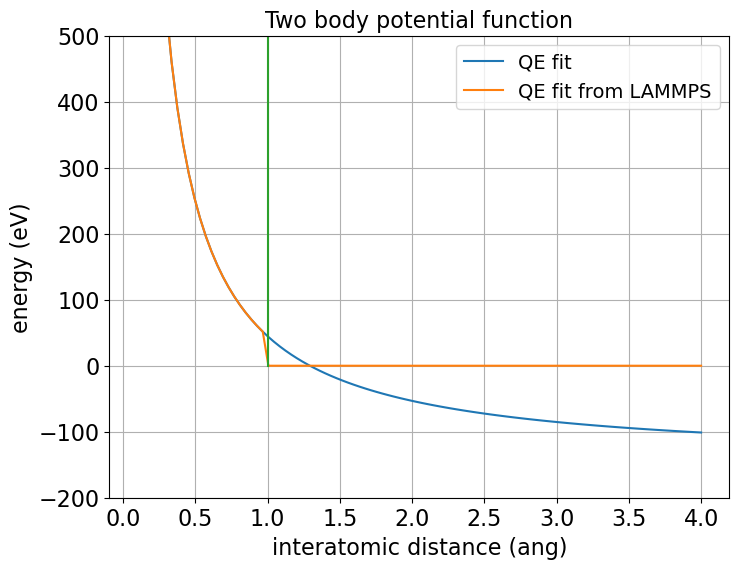

In [112]:
fs = 16

fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot(111)

ax.plot(result_lmp_df['distance'], result_lmp_df['qefit'],label='QE fit')
ax.plot(result_lmp_df['distance'], result_lmp_df['energy'],label='QE fit from LAMMPS')

ax.plot([1]*10, np.linspace(0, 500, 10))

ax.set_title('Two body potential function', fontsize=fs)
ax.set_xlabel('interatomic distance (ang)', fontsize=fs)
ax.set_ylabel('energy (eV)', fontsize=fs)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid()
ax.legend(fontsize=14)

# ax.set_ylim(-5, 10)
ax.set_ylim(-200, 500)

fig.show()

In [113]:
# Plot two-body potential of gafit (lammps output)
path2target = '/Users/y1u0d2/desktop/Lab/result/lammps/Si/two-body-potential/gafit/01'
pathes = glob(f'{path2target}/tb*')
pathes.sort()

result_lmp = []
for path in pathes:
    r_from_path = float(path.split('/')[-1].split('_')[-1])
    obj = LammpsLogParser(path2target=path, dump_filename='dump.out')
    energy = obj.get_energy()
    result_lmp.append([r_from_path, energy])

result_lmp_df = pd.DataFrame(data=result_lmp, columns=['distance', 'energy'])

In [114]:
result_lmp_df['gafit'] = result_lmp_df['distance'].apply(ga_fit_func)

/var/folders/hl/8xx4rtm50t7czkr79gggbqqr0000gr/T/ipykernel_54886/2851388405.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


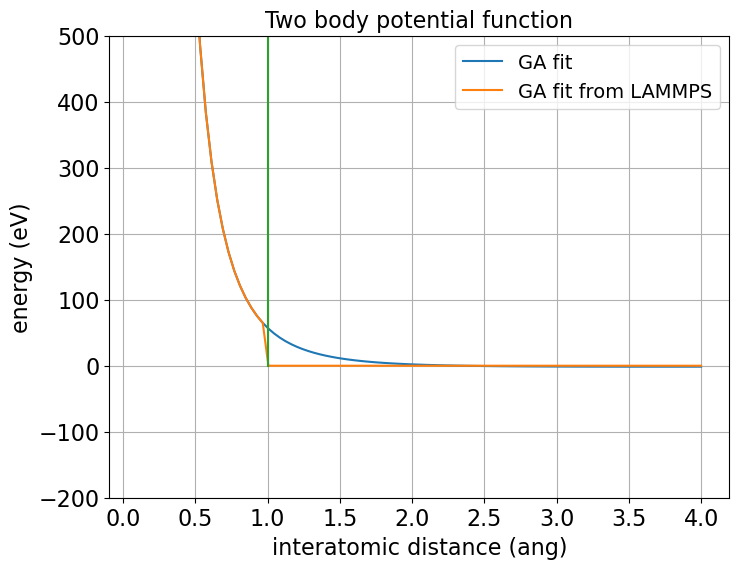

In [115]:
fs = 16

fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot(111)

ax.plot(result_lmp_df['distance'], result_lmp_df['gafit'],label='GA fit')
ax.plot(result_lmp_df['distance'], result_lmp_df['energy'],label='GA fit from LAMMPS')

ax.plot([1]*10, np.linspace(0, 500, 10))

ax.set_title('Two body potential function', fontsize=fs)
ax.set_xlabel('interatomic distance (ang)', fontsize=fs)
ax.set_ylabel('energy (eV)', fontsize=fs)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid()
ax.legend(fontsize=14)

# ax.set_ylim(-5, 10)
ax.set_ylim(-200, 500)

fig.show()